In [15]:
import numpy as np
import pandas as pd

from src.constant import DATA_DIR, DATABASE_DIR
from src.database import DB
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver
from src.aac.SurrogateEstimator import Estimator1

import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0


In [2]:
generators = [
    "cluster_netgen",
    "compression",
    "expansion",
    "explosion",
    "grid",
    "cluster",
    "implosion",
    "linearprojection",
    "rotation",
    "uniform_portgen",
]

test_instances = TSP_from_index_file(filepath=DATA_DIR / "TSP" / "TEST" / "index.json")

id_to_generator_name = {
    instance.id(): instance.filepath.parts[-2] for instance in test_instances
}

id_to_name = {
    instance.id(): instance.filepath.parts[-1] for instance in test_instances
}

### feature importance

In [31]:
db_path = list(DATABASE_DIR.glob(f"run-plain-30-*.db"))[0]
db = DB(db_path)

query = f"""
    select 
        {db.SCHEMA.EVALUATIONS}.cost,
        {db.SCHEMA.SOLVERS}.*,
        {db.SCHEMA.INSTANCES}.*
    from {db.SCHEMA.EVALUATIONS}
    join {db.SCHEMA.INSTANCES} on {db.SCHEMA.EVALUATIONS}.instance_id = {db.SCHEMA.INSTANCES}.id
    join {db.SCHEMA.SOLVERS} on {db.SCHEMA.EVALUATIONS}.solver_id = {db.SCHEMA.SOLVERS}.id
    """
df = db.query2df(query)
df = df.drop(columns=["id", "filepath", "optimum"])
df = df.dropna()
y = df["cost"]
X = df.drop(columns="cost")
COLUMNS = X.columns

In [45]:
prefix = "run-plain-250"

feature_importance_regressor = []
feature_importance_classifier = []

for db_path in DATABASE_DIR.glob(f"{prefix}-*.db"):
    db = DB(db_path)

    X, y = get_model_training_data(db)
    estimator = Estimator1(
        max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=0.5
    )
    estimator.fit(X, y)

    s = pd.Series(dict(zip(COLUMNS, estimator.classifier.feature_importances_)))
    feature_importance_classifier.append(s)

    s = pd.Series(dict(zip(COLUMNS, estimator.regressor.feature_importances_)))
    feature_importance_regressor.append(s)

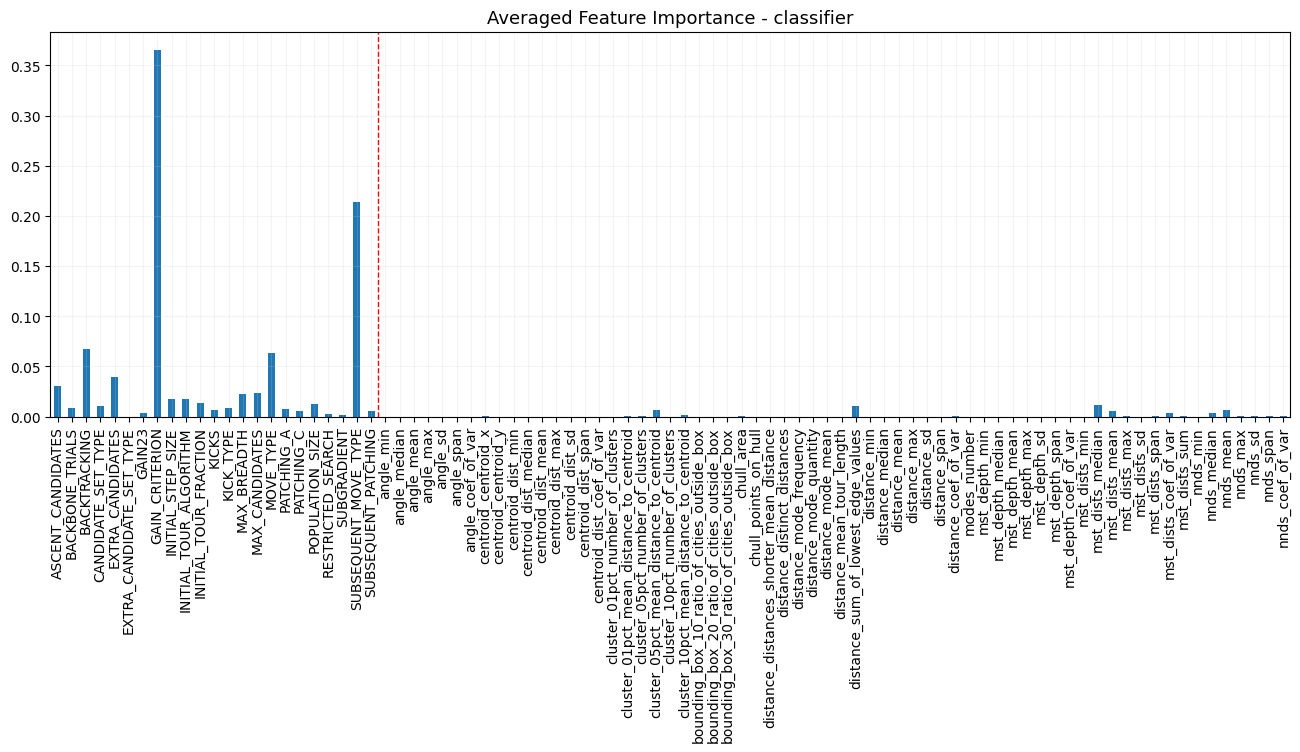

In [50]:
s = pd.concat(feature_importance_classifier, axis=1).mean(axis=1)
s.plot.bar(figsize=(16, 5))
plt.axvline(x=22.5, c="red", lw=1, ls="--")
plt.title("Averaged Feature Importance - classifier", size=13)
plt.savefig("feature_importance_classifier.png", dpi=300, bbox_inches="tight")
plt.show()

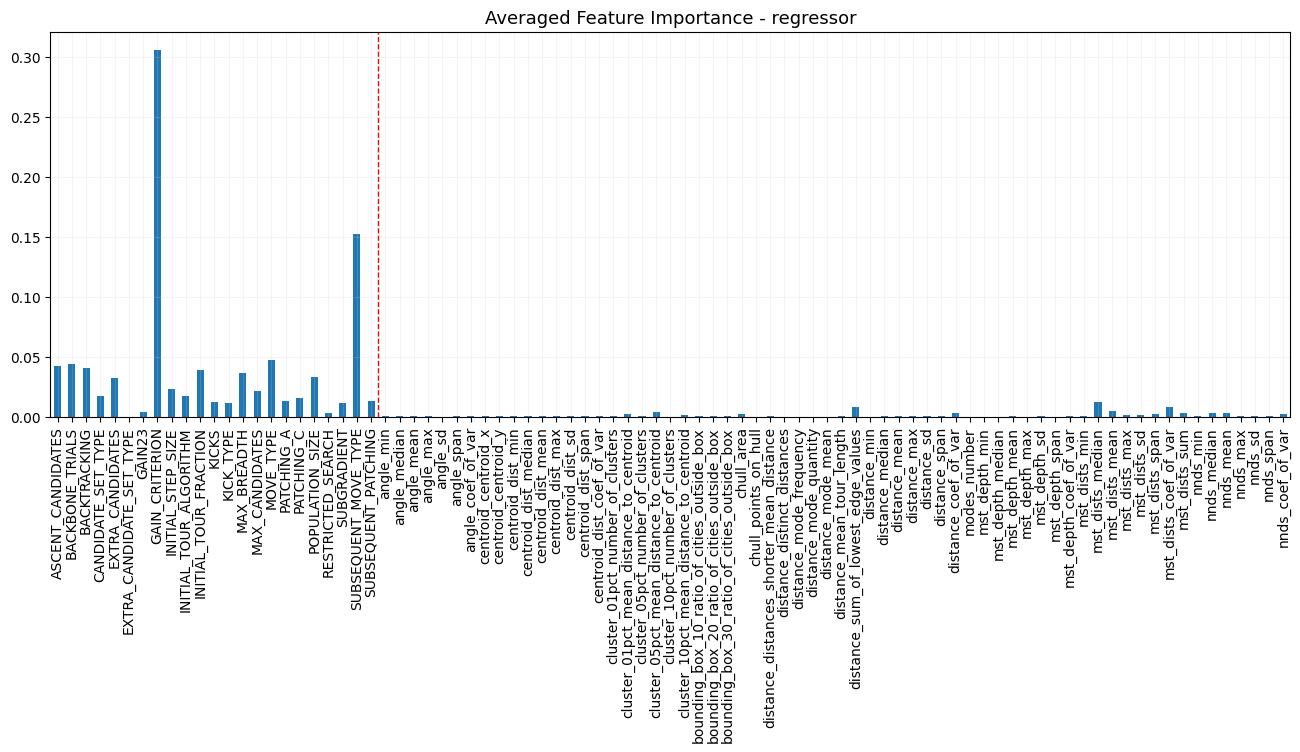

In [52]:
s = pd.concat(feature_importance_regressor, axis=1).mean(axis=1)
s.plot.bar(figsize=(16, 5))
plt.axvline(x=22.5, c="red", lw=1, ls="--")
plt.title("Averaged Feature Importance - regressor", fontsize=13)
plt.savefig("feature_importance_regressor.png", dpi=300, bbox_inches="tight")
plt.show()

### large test set

In [ ]:
X_list = []
y_list = []

for prefix in ["run-plain-30", "run-plain-250", "run-plain-500"]:
    for db_path in DATABASE_DIR.glob(f"{prefix}-*.db"):
        db = DB(db_path)
        X, y = get_model_training_data(db)
        X_list.append(X)
        y_list.append(y)
    
X_test = np.concatenate(X_list, axis=0)
y_test = np.concatenate(y_list, axis=0)

In [44]:
prefix = "run-plain-500"

acc_list = []
rmse_list = []
training_data_shape_list = []
non_timeout_training_data_shape_list = []
for db_path in DATABASE_DIR.glob(f"{prefix}-*.db"):
    db = DB(db_path)

    X, y = get_model_training_data(db)
    estimator = Estimator1(
        max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=0.5
    )
    estimator.fit(X, y)
    acc_, rmse = estimator.score(X_test, y_test)
    training_data_shape = X.shape[0]
    non_timeout_training_data_shape = X[estimator._mask_non_timeout].shape[0]
    acc_list.append(acc_)
    rmse_list.append(rmse)
    training_data_shape_list.append(training_data_shape)
    non_timeout_training_data_shape_list.append(non_timeout_training_data_shape)

acc = np.mean(acc_list)
rmse = np.mean(rmse_list)
training_data_shape = np.mean(training_data_shape_list)
non_timeout_training_data_shape = np.mean(non_timeout_training_data_shape_list)

print(f"{acc=:.4f}, {rmse=:.4f}, {training_data_shape=:.1f}, {non_timeout_training_data_shape=:.1f}")

acc=0.7990, rmse=2.0140, training_data_shape=75000.0, non_timeout_training_data_shape=39751.0
